In [161]:
 """ === SIMPLE EXAMPLE TO EXPLAIN TRUST CALCULATION ===

Imagine we observed the partner's behavior in 4 rounds:
match_history = [1, 0, 1, 1]  → 1 = matched expected behavior, 0 = didn't match

Let discount_factor = 0.9  → recent behavior is more important

So we assign weights to each round, from oldest to newest:
weights = [0.9^3, 0.9^2, 0.9^1, 0.9^0] = [0.729, 0.81, 0.9, 1.0]

Multiply each match by its weight:
Round 1: 1 × 0.729 = 0.729
Round 2: 0 × 0.81  = 0.0
Round 3: 1 × 0.9   = 0.9
Round 4: 1 × 1.0   = 1.0

Total weighted match score = 0.729 + 0.0 + 0.9 + 1.0 = 2.629
Total weights = 0.729 + 0.81 + 0.9 + 1.0 = 3.439

So consistency = 2.629 / 3.439 ≈ 0.764

This means the partner is about 76.4% consistent (with more recent behavior counting more).

Then we convert this consistency into target trust:
target_trust = 1.0 + (5.0 - 1.0) * consistency
             = 1.0 + 4.0 * 0.764 ≈ 4.06

Finally, we update the current trust smoothly toward 4.06, depending on how quickly we want it to change
(using a "trust_smoothing" factor like 0.1 or 0.2) """

' === SIMPLE EXAMPLE TO EXPLAIN TRUST CALCULATION ===\n\nImagine we observed the partner\'s behavior in 4 rounds:\nmatch_history = [1, 0, 1, 1]  → 1 = matched expected behavior, 0 = didn\'t match\n\nLet discount_factor = 0.9  → recent behavior is more important\n\nSo we assign weights to each round, from oldest to newest:\nweights = [0.9^3, 0.9^2, 0.9^1, 0.9^0] = [0.729, 0.81, 0.9, 1.0]\n\nMultiply each match by its weight:\nRound 1: 1 × 0.729 = 0.729\nRound 2: 0 × 0.81  = 0.0\nRound 3: 1 × 0.9   = 0.9\nRound 4: 1 × 1.0   = 1.0\n\nTotal weighted match score = 0.729 + 0.0 + 0.9 + 1.0 = 2.629\nTotal weights = 0.729 + 0.81 + 0.9 + 1.0 = 3.439\n\nSo consistency = 2.629 / 3.439 ≈ 0.764\n\nThis means the partner is about 76.4% consistent (with more recent behavior counting more).\n\nThen we convert this consistency into target trust:\ntarget_trust = 1.0 + (5.0 - 1.0) * consistency\n            = 1.0 + 4.0 * 0.764 ≈ 4.06\n\nFinally, we update the current trust smoothly toward 4.06, depending 

In [162]:
# 1) Imports & seed
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt  

np.random.seed(42)
random.seed(42)

# 2) Game data + helper
payoff = np.array([
    [[2, 2], [3, 0]], 
    [[0, 3], [4, 4]]
])

def get_payoff(player1_strategy, player2_strategy, player_id):
    return payoff[int(player1_strategy), int(player2_strategy), int(player_id)]

def stag_indifference_threshold():
    a00 = get_payoff(0,0,0); a01 = get_payoff(0,1,0)
    a10 = get_payoff(1,0,0); a11 = get_payoff(1,1,0)
    den = (a00 - a10) + (a11 - a01)
    return float((a00 - a10)/den) if den != 0 else 0.5


# 3) Constants
MEMORY_DISCOUNT = 0.9
TRUST_DISCOUNT  = 0.6
TRUST_SMOOTHING = 0.1
TRUST_MIN = 0  
TRUST_MAX = 5.0
EPS = 1e-6

In [163]:
# 4) Core agent
class FocalAgent:
    def __init__(self, 
                 u_i: float = None, 
                 t_init: float = 0, 
                 eta: float = 0.1, 
                 noise_sigma: float = 0.02, 
                 memory_discount: float = MEMORY_DISCOUNT,
                 trust_discount: float = TRUST_DISCOUNT,
                 trust_smoothing: float = TRUST_SMOOTHING,
                 stochastic: bool = True,
                 inv_temp: float = 2.0):
        if not 0 <= memory_discount <= 1:
            raise ValueError("memory_discount must be in [0,1]")
        if not 0 <= trust_discount <= 1:
            raise ValueError("trust_discount must be in [0,1]")
        if not 0 <= trust_smoothing <= 1:
            raise ValueError("trust_smoothing must be in [0,1]")
        if u_i is not None and not 0 <= u_i <= 1:
            raise ValueError("u_i must be between 0 and 1")
        if not 0 <= eta <= 5:
            raise ValueError("eta must be between  [0,1]")

        self.x = u_i if u_i is not None else 1 - ((get_payoff(0,0,0) - get_payoff(1,0,0)) /
                                                  ((get_payoff(0,0,0) - get_payoff(1,0,0)) + 
                                                   (get_payoff(1,1,0) - get_payoff(0,1,0))))
        self.t = t_init
        self.eta = eta
        self.noise_sigma = noise_sigma
        self.memory_discount = memory_discount
        self.trust_discount = trust_discount
        self.trust_smoothing = trust_smoothing
        self.stochastic = stochastic
        self.inv_temp = inv_temp # Lambda in the logistic function for stochastic choice
        self.match_history = []   # for trust
        self.action_history = []  # for signal

    def expected_p(self) -> float:
        alpha = EPS + self.x * self.t
        beta  = EPS + (1 - self.x) * self.t
        return alpha / (alpha + beta)

    def make_decision(self) -> int:
        p = self.expected_p()
        a00 = get_payoff(0,0,0); a01 = get_payoff(0,1,0)
        a10 = get_payoff(1,0,0); a11 = get_payoff(1,1,0)
        EV_hare = (1 - p) * a00 + p * a01
        EV_stag = (1 - p) * a10 + p * a11
        D = EV_stag - EV_hare
        if not self.stochastic:
            return 1 if D > 0 else 0
        # probabilistic (logit) choice:
        prob_stag = 1.0 / (1.0 + np.exp(-self.inv_temp * D))
        return 1 if random.random() < prob_stag else 0

    def compute_new_trust(self, partner_choice: int) -> float:
        expected_choice = 1 if self.x > 0.5 else 0
        match = 1 if partner_choice == expected_choice else 0

        # 1) compute target from history so far (without this round)_past only target
        if not self.match_history:
            target_trust = self.t  # no history → stick with current trust
        else:
            weights = [self.trust_discount ** i for i in range(len(self.match_history)-1, -1, -1)]
            consistency = sum(m * w for m, w in zip(self.match_history, weights)) / sum(weights)
            target_trust = TRUST_MIN + (TRUST_MAX - TRUST_MIN) * consistency

        # 2) smooth toward the target(no current round info yet)
        new_trust = (1 - self.trust_smoothing) * self.t + self.trust_smoothing * target_trust
        new_trust = float(np.clip(new_trust, TRUST_MIN, TRUST_MAX))

        # 3) record this round for *next* target computation
        self.match_history.append(match)
        return new_trust

    def compute_new_signal(self, partner_choice: int) -> float:
        """Recency-weighted observation update + small noise."""
        # --- past-only observation estimate ---
        if self.action_history:
            weights = [self.memory_discount ** i for i in range(len(self.action_history)-1, -1, -1)]
            P_obs = sum(a * w for a, w in zip(self.action_history, weights)) / sum(weights)
        else:
            P_obs = self.x  # no past observations → stick with current belief

        noise = np.random.normal(0, self.noise_sigma)
        new_signal = float(np.clip(self.x + self.eta * (P_obs - self.x) + noise, 0.0, 1.0))

        # record current partner action *after* computing (available next round)
        self.action_history.append(int(partner_choice))
        return new_signal

    def update_state(self, new_trust: float, new_signal: float):
        self.t = new_trust
        self.x = new_signal

In [164]:
# 5) Partners (belief-driven)
class BeliefDrivenPartnerBase:
    """
    Partner maintains its own beliefs (x_hat in [0,1], t_hat in [t_min,t_max])
    and updates via recency-weighted actions and consistency-based trust.
    """
    def __init__(self, 
                 u_i: float = None, 
                 t0: float = 0.0,
                 eta: float = 0.1, 
                 noise_sigma: float = 0.02, 
                 memory_discount: float = MEMORY_DISCOUNT,
                 trust_discount: float = TRUST_DISCOUNT,
                 trust_smoothing: float = TRUST_SMOOTHING,
                 t_min: float = TRUST_MIN, 
                 t_max: float = TRUST_MAX):
        if u_i is not None and not 0 <= u_i <= 1:
            raise ValueError("u_i must be between 0 and 1")
        if not t_min <= t0 <= t_max:
            raise ValueError("t0 must be between t_min and t_max")

        self.x_hat = u_i if u_i is not None else 1 - ((get_payoff(0,0,0) - get_payoff(1,0,0)) /
                                                  ((get_payoff(0,0,0) - get_payoff(1,0,0)) + 
                                                   (get_payoff(1,1,0) - get_payoff(0,1,0))))
        self.t_hat = float(t0)
        self.eta = eta
        self.noise_sigma = noise_sigma
        self.memory_discount = memory_discount
        self.trust_discount = trust_discount
        self.trust_smoothing = trust_smoothing
        self.t_min = t_min
        self.t_max = t_max
        self.match_history = []
        self.obs_actions = []

    def _expected_choice_from_signal(self, x): return 1 if x > 0.5 else 0

    def _target_trust_from_history(self):
        if not self.match_history:
            return self.t_hat  # no history → stick with current trust
        weights = [self.trust_discount ** i for i in range(len(self.match_history)-1, -1, -1)]
        consistency = sum(m*w for m, w in zip(self.match_history, weights)) / sum(weights)
        return self.t_min + (self.t_max - self.t_min) * consistency

    def _update_trust(self, observed_action):
        expected_choice = self._expected_choice_from_signal(self.x_hat)
        match = 1 if observed_action == expected_choice else 0

        # symmetry with FocalAgent: compute target from existing history first
        T_target = self._target_trust_from_history()
        self.match_history.append(match)

        new_t = (1 - self.trust_smoothing) * self.t_hat + self.trust_smoothing * T_target
        self.t_hat = float(np.clip(new_t, self.t_min, self.t_max))

    def _update_signal(self):
        if self.obs_actions:
            weights = [self.memory_discount ** i for i in range(len(self.obs_actions)-1, -1, -1)]
            P_obs = sum(a*w for a, w in zip(self.obs_actions, weights)) / sum(weights)
        else:
            P_obs = self.x_hat
        noise = np.random.normal(0, self.noise_sigma)
        self.x_hat = float(np.clip(self.x_hat + self.eta * (P_obs - self.x_hat) + noise, 0.0, 1.0))

    # API
    def decide(self, round_num:int, last_agent_choice:int|None=None) -> int:
        raise NotImplementedError
    def observe(self, focal_agent_action:int):
        self._update_trust(focal_agent_action)
        self._update_signal()
        self.obs_actions.append(int(focal_agent_action))

class AdaptivePartner(BeliefDrivenPartnerBase):
    def decide(self, round_num, last_agent_choice=None):
        return 1 if self.x_hat > 0.5 else 0

class StrategicCheaterPartner(BeliefDrivenPartnerBase):
    def __init__(self, t_threshold=2.5, **kwargs):
        super().__init__(**kwargs); self.t_threshold = t_threshold
    def decide(self, round_num, last_agent_choice=None):
        return 0 if self.t_hat > self.t_threshold else 1

class ExpectationViolationPartner(BeliefDrivenPartnerBase):
    """“chooses the opposite of its forecast of the agent’s action.”"""
    def decide(self, round_num, last_agent_choice=None):
        return 0 if self.x_hat > 0.5 else 1

In [165]:

# 6) Partners (fixed strategies)

class PeriodicCheaterPartner:
    """
    Cooperate for `cycle_length` rounds, then defect for `cheat_duration` rounds, repeat.
    """
    def __init__(self, cycle_length=6, cheat_duration=2):
        self.cycle_length = cycle_length
        self.cheat_duration = cheat_duration
    def decide(self, round_num, last_agent_choice=None):
        return 1 if (round_num % (self.cycle_length + self.cheat_duration)) < self.cycle_length else 0
    def observe(self, focal_agent_action:int):
        pass  # no learning

class SingleCyclePartner:
    """
    Cooperate for the first `cooperate_rounds` rounds, then defect thereafter.
    """
    def __init__(self, cooperate_rounds=30):
        self.cooperate_rounds = cooperate_rounds
    def decide(self, round_num, last_agent_choice=None):
        return 1 if round_num < self.cooperate_rounds else 0
    def observe(self, focal_agent_action:int):
        pass
class ProbabilisticPartner: 
    """
    Cooperate with a fixed probability.
    """
    def __init__(self, cooperate_prob=0.7):
        if not 0 <= cooperate_prob <= 1:
            raise ValueError("cooperate_prob must be in [0,1]")
        self.cooperate_prob = cooperate_prob
    def decide(self, round_num, last_agent_choice=None):
        return 1 if random.random() < self.cooperate_prob else 0
    def observe(self, focal_agent_action:int):
        pass
class TitForTatCooperatePartner:
    """
    Start by cooperating; afterwards mirror the focal agent's last action.
    """
    def decide(self, round_num, last_agent_choice=None):
        return 1 if last_agent_choice is None else int(last_agent_choice)
    def observe(self, focal_agent_action:int):
        pass

class TitForTatDefectPartner:
    """
    Start by defecting; afterwards mirror the focal agent's last action.
    """
    def decide(self, round_num, last_agent_choice=None):
        return 0 if last_agent_choice is None else int(last_agent_choice)
    def observe(self, focal_agent_action:int):
        pass

class AlwaysCollaboratePartner:
    def decide(self, round_num, last_agent_choice=None):
        return 1
    def observe(self, focal_agent_action:int):
        pass

class AlwaysDefectPartner:
    def decide(self, round_num, last_agent_choice=None):
        return 0
    def observe(self, focal_agent_action:int):
        pass

class RandomPartner:
    def decide(self, round_num, last_agent_choice=None):
        return random.choice([0, 1])
    def observe(self, focal_agent_action:int):
        pass

In [166]:
# 7) Simulation
def run_single_agent_simulation(
    u_i: float = None, 
    stochastic: bool = True,
    inv_temp: float = 2.0,
    seed=None,
    num_rounds: int = 70,
    partner_obj = None,
    initial_last_choice: int = 1,
    memory_discount: float = MEMORY_DISCOUNT,
    trust_discount: float = TRUST_DISCOUNT,
    trust_smoothing: float = TRUST_SMOOTHING,
    eta: float = 0.1,
    noise_sigma: float = 0.02
) -> pd.DataFrame:
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    """Run simulation with separate discounting for memory and trust."""
    if partner_obj is None:
        raise ValueError("Provide a partner_obj instance")

    agent = FocalAgent(
        u_i=u_i,
        memory_discount=memory_discount,
        trust_discount=trust_discount,
        trust_smoothing=trust_smoothing,
        stochastic=stochastic,
        inv_temp=inv_temp,
        eta=eta,
        noise_sigma=noise_sigma
    )

    results = []
    last_agent_choice = initial_last_choice

    for round_num in range(num_rounds):
        agent_choice = agent.make_decision()

        # Allow both class-based and callable partners
        if hasattr(partner_obj, "decide"):
            partner_choice = partner_obj.decide(round_num, last_agent_choice)
        else:
            try:
                partner_choice = partner_obj(round_num)
            except TypeError:
                partner_choice = partner_obj(last_agent_choice)

        new_trust  = agent.compute_new_trust(partner_choice)
        new_signal = agent.compute_new_signal(partner_choice)
        agent.update_state(new_trust, new_signal)

        if hasattr(partner_obj, "observe"):
            partner_obj.observe(agent_choice)

        last_agent_choice = agent_choice
        E_p = agent.expected_p() 
        results.append((round_num + 1, agent_choice, partner_choice, agent.x, agent.t, E_p))

    return pd.DataFrame(results, columns=["Round","Agent_Choice","Partner_Choice","Agent_Signal","Agent_Trust", "E_p"])

In [167]:
# Set simulation parameters
num_rounds = 70  
discount_factor = 0.6 
trust_smoothing = 0.1  

In [168]:
# Run simulations with all partner strategies
sim_results_cheating = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=PeriodicCheaterPartner(cycle_length=6, cheat_duration=2),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing)

sim_results_cheating_partner_cycle = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=SingleCyclePartner(cooperate_rounds=30),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing)

sim_results_probabilistic = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds,
    partner_obj=ProbabilisticPartner(cooperate_prob=0.7),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing)

sim_results_strategic_cheater = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=StrategicCheaterPartner(),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing)

sim_results_tit_for_tat_coop = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=TitForTatCooperatePartner(),
    initial_last_choice=1,
    memory_discount=discount_factor, trust_smoothing=trust_smoothing)

sim_results_tit_for_tat_defect = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=TitForTatDefectPartner(),
    initial_last_choice=0,
    memory_discount=discount_factor, trust_smoothing=trust_smoothing)

sim_results_collab = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=AlwaysCollaboratePartner(),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing)

sim_results_defect = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=AlwaysDefectPartner(),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing)

sim_results_random = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=RandomPartner(),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing)

sim_results_adaptive = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=AdaptivePartner(),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing)

sim_results_expect_violation = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=ExpectationViolationPartner(),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing)

In [169]:
df_cheating = pd.DataFrame(sim_results_cheating)
df_cheating_partner_cycle = pd.DataFrame(sim_results_cheating_partner_cycle)
df_prob_cheater = pd.DataFrame(sim_results_probabilistic)
df_strategic_cheater = pd.DataFrame(sim_results_strategic_cheater)
df_tit_for_tat_coop = pd.DataFrame(sim_results_tit_for_tat_coop)
df_tit_for_tat_defect = pd.DataFrame(sim_results_tit_for_tat_defect)
df_collab = pd.DataFrame(sim_results_collab)
df_defect = pd.DataFrame(sim_results_defect)
df_random = pd.DataFrame(sim_results_random)
df_adaptive = pd.DataFrame(sim_results_adaptive)
df_expect_violation = pd.DataFrame(sim_results_expect_violation)

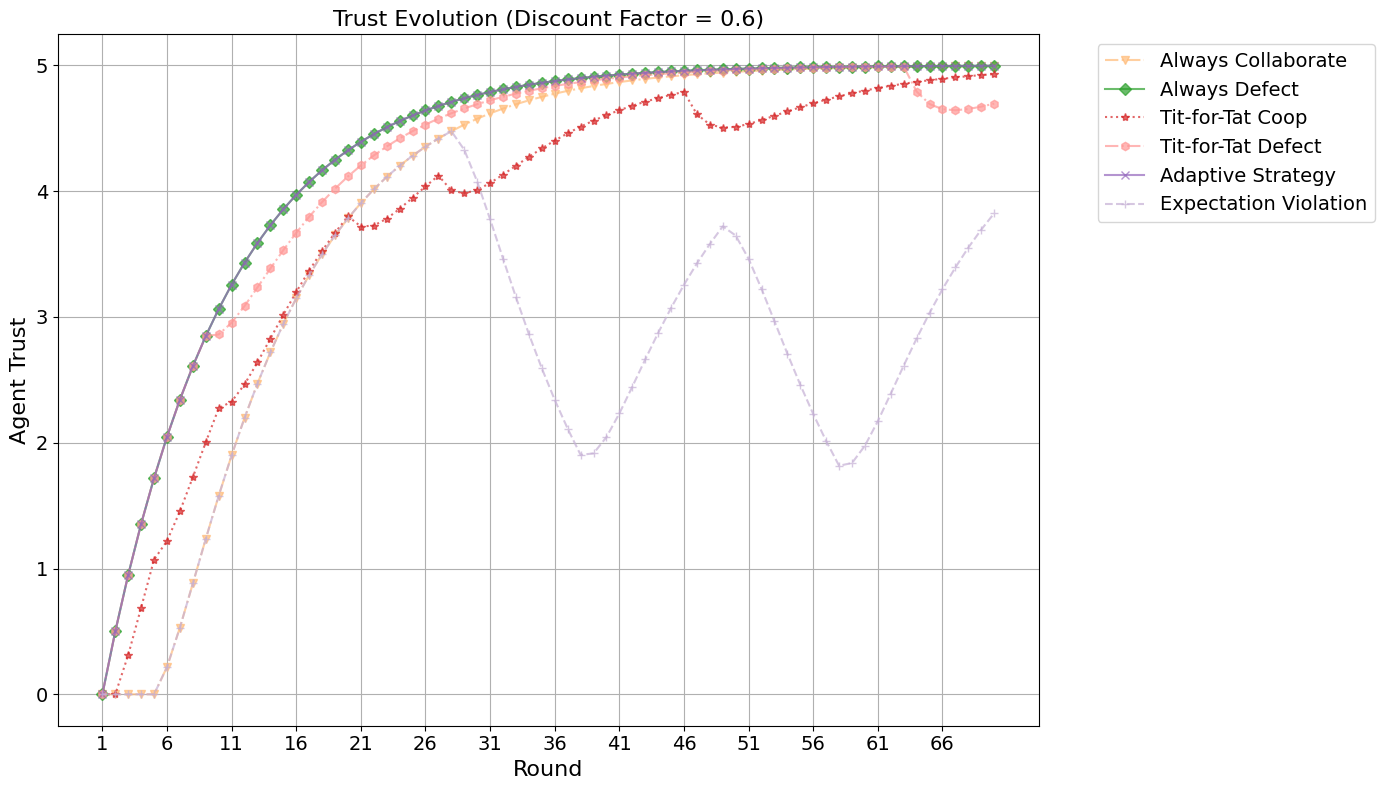

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a distinct color palette (using seaborn's "tab10" or "tab20" for more colors)
colors = sns.color_palette("tab20", 10)  # 10 distinct colors for 10 strategies

# Define line styles and markers to differentiate the lines
line_styles = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']
markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'x', '+']

# Visualize Trust Evolution
plt.figure(figsize=(14, 8))  # Increase figure size

plt.plot(df_collab["Round"], df_collab["Agent_Trust"], label="Always Collaborate", 
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)

plt.plot(df_defect["Round"], df_defect["Agent_Trust"], label="Always Defect", 
         color=colors[4], linestyle=line_styles[4], marker=markers[4], alpha=0.7)

plt.plot(df_tit_for_tat_coop["Round"], df_tit_for_tat_coop["Agent_Trust"], label="Tit-for-Tat Coop", 
         color=colors[6], linestyle=line_styles[6], marker=markers[6], alpha=0.7)

plt.plot(df_tit_for_tat_defect["Round"], df_tit_for_tat_defect["Agent_Trust"], label="Tit-for-Tat Defect", 
         color=colors[7], linestyle=line_styles[7], marker=markers[7], alpha=0.7)

plt.plot(df_adaptive["Round"], df_adaptive["Agent_Trust"], label="Adaptive Strategy", 
         color=colors[8], linestyle=line_styles[8], marker=markers[8], alpha=0.7)

plt.plot(df_expect_violation["Round"], df_expect_violation["Agent_Trust"], label="Expectation Violation", 
         color=colors[9], linestyle=line_styles[9], marker=markers[9], alpha=0.7)

plt.xlabel("Round", fontsize=16)
plt.ylabel("Agent Trust", fontsize=16)
plt.title(f"Trust Evolution (Discount Factor = {discount_factor})", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)  # Move legend outside
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

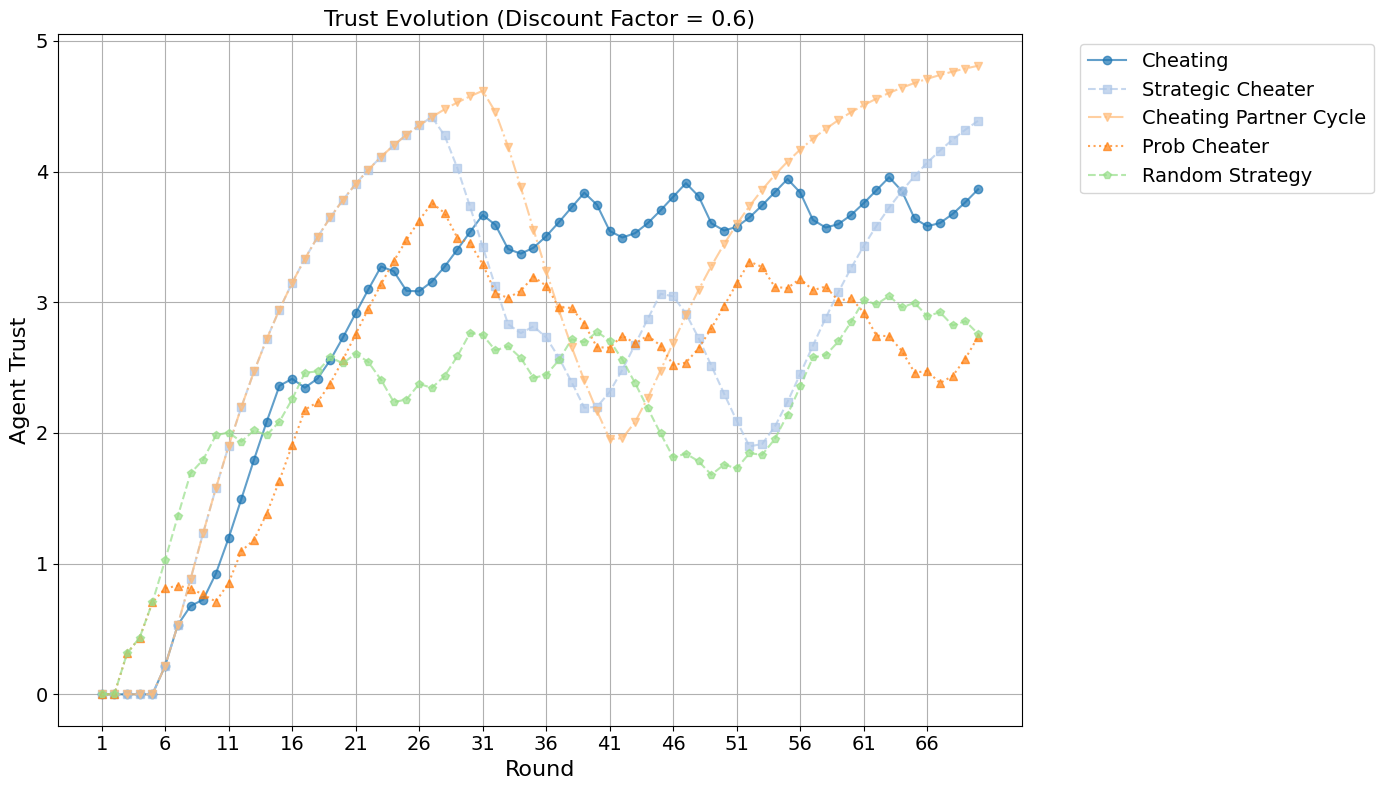

In [171]:
plt.figure(figsize=(14, 8))  # Increase figure size
plt.plot(df_cheating["Round"], df_cheating["Agent_Trust"], label="Cheating", 
         color=colors[0], linestyle=line_styles[0], marker=markers[0], alpha=0.7)
plt.plot(df_strategic_cheater["Round"], df_strategic_cheater["Agent_Trust"], label="Strategic Cheater", 
         color=colors[1], linestyle=line_styles[1], marker=markers[1], alpha=0.7)
plt.plot(df_cheating_partner_cycle["Round"], df_cheating_partner_cycle["Agent_Trust"], label="Cheating Partner Cycle",
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)
plt.plot(df_prob_cheater["Round"], df_prob_cheater["Agent_Trust"], label="Prob Cheater", 
         color=colors[2], linestyle=line_styles[2], marker=markers[2], alpha=0.7)
plt.plot(df_random["Round"], df_random["Agent_Trust"], label="Random Strategy", 
         color=colors[5], linestyle=line_styles[5], marker=markers[5], alpha=0.7)

plt.xlabel("Round", fontsize=16)
plt.ylabel("Agent Trust", fontsize=16)
plt.title(f"Trust Evolution (Discount Factor = {discount_factor})", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)  # Move legend outside
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

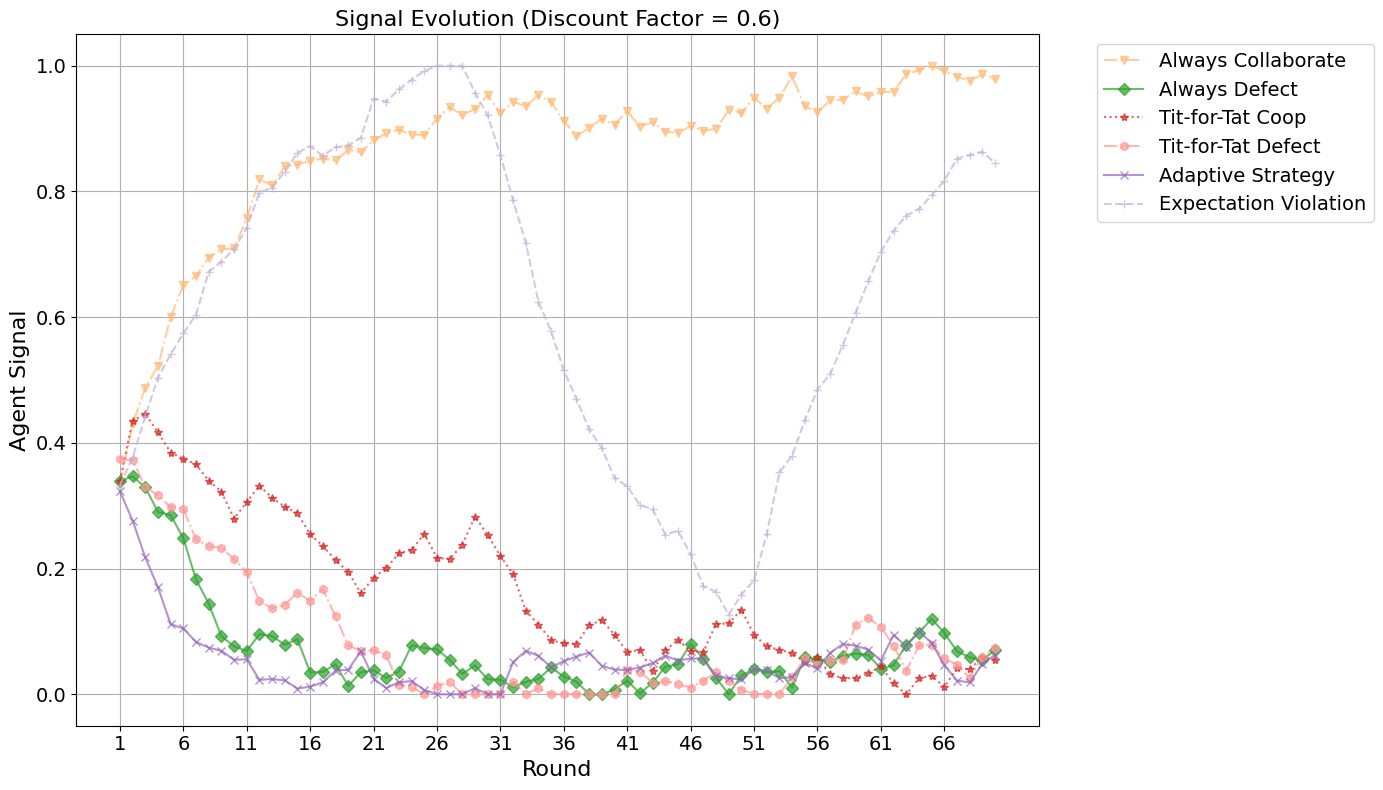

In [172]:
# Visualize Signal Evolution
plt.figure(figsize=(14, 8))  # Increase figure size

plt.plot(df_collab["Round"], df_collab["Agent_Signal"], label="Always Collaborate", 
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)

plt.plot(df_defect["Round"], df_defect["Agent_Signal"], label="Always Defect", 
         color=colors[4], linestyle=line_styles[4], marker=markers[4], alpha=0.7)

plt.plot(df_tit_for_tat_coop["Round"], df_tit_for_tat_coop["Agent_Signal"], label="Tit-for-Tat Coop", 
         color=colors[6], linestyle=line_styles[6], marker=markers[6], alpha=0.7)

plt.plot(df_tit_for_tat_defect["Round"], df_tit_for_tat_defect["Agent_Signal"], label="Tit-for-Tat Defect", 
         color=colors[7], linestyle=line_styles[7], marker=markers[7], alpha=0.7)

plt.plot(df_adaptive["Round"], df_adaptive["Agent_Signal"], label="Adaptive Strategy", 
         color=colors[8], linestyle=line_styles[8], marker=markers[8], alpha=0.7)

plt.plot(df_expect_violation["Round"], df_expect_violation["Agent_Signal"], label="Expectation Violation", 
         color=colors[9], linestyle=line_styles[9], marker=markers[9], alpha=0.7)


plt.xlabel("Round", fontsize=16)
plt.ylabel("Agent Signal", fontsize=16)
plt.title(f"Signal Evolution (Discount Factor = {discount_factor})", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)  # Move legend outside
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

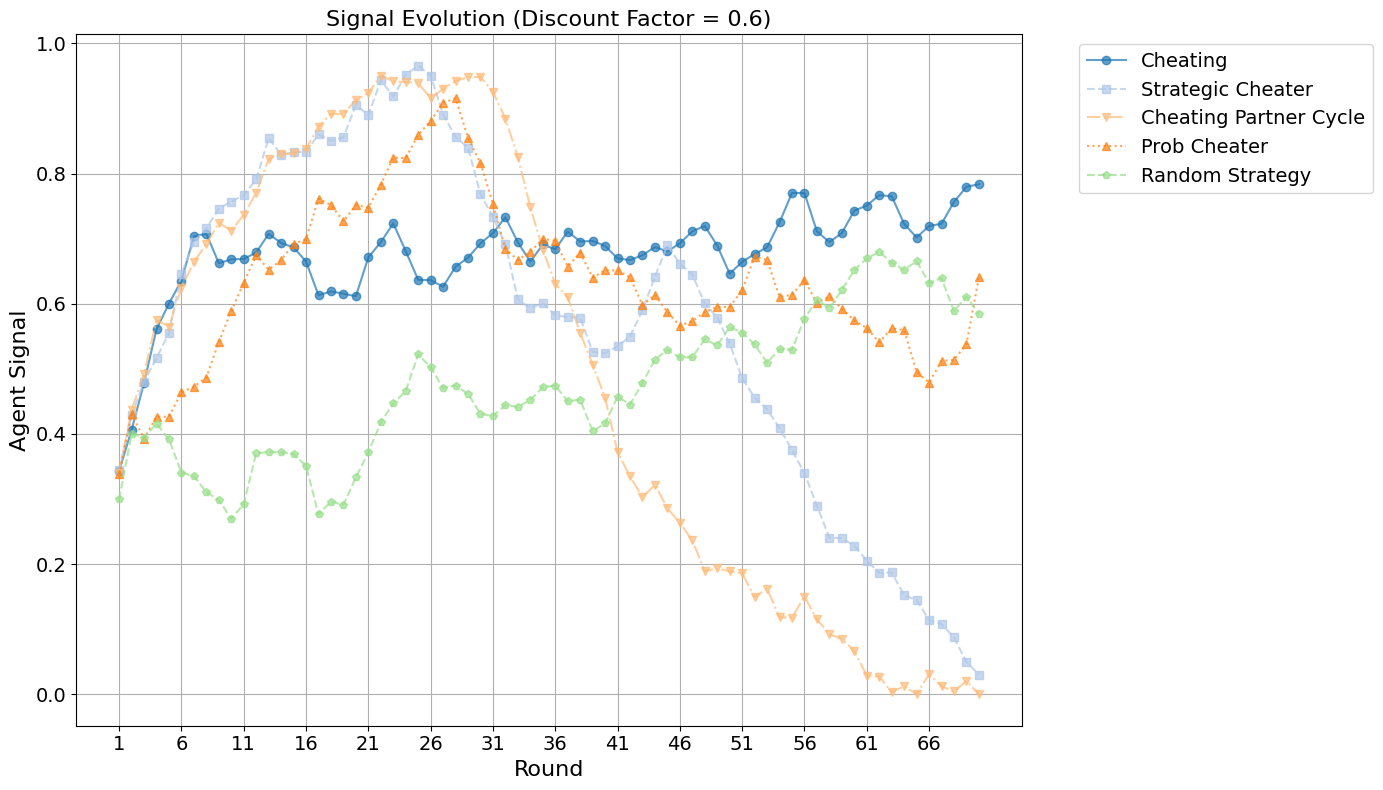

In [173]:
plt.figure(figsize=(14, 8))  # Increase figure size
plt.plot(df_cheating["Round"], df_cheating["Agent_Signal"], label="Cheating", 
         color=colors[0], linestyle=line_styles[0], marker=markers[0], alpha=0.7)
plt.plot(df_strategic_cheater["Round"], df_strategic_cheater["Agent_Signal"], label="Strategic Cheater", 
         color=colors[1], linestyle=line_styles[1], marker=markers[1], alpha=0.7)
plt.plot(df_cheating_partner_cycle["Round"], df_cheating_partner_cycle["Agent_Signal"], label="Cheating Partner Cycle",
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)
plt.plot(df_prob_cheater["Round"], df_prob_cheater["Agent_Signal"], label="Prob Cheater", 
         color=colors[2], linestyle=line_styles[2], marker=markers[2], alpha=0.7)
plt.plot(df_random["Round"], df_random["Agent_Signal"], label="Random Strategy", 
         color=colors[5], linestyle=line_styles[5], marker=markers[5], alpha=0.7)

plt.xlabel("Round", fontsize=16)
plt.ylabel("Agent Signal", fontsize=16)
plt.title(f"Signal Evolution (Discount Factor = {discount_factor})", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)  # Move legend outside 
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

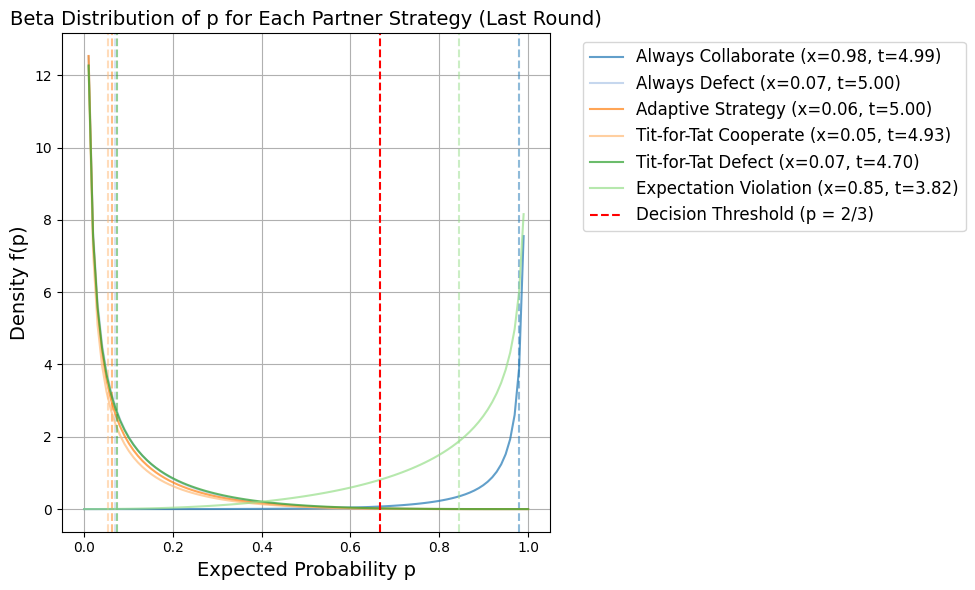

In [174]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# List of DataFrames and their corresponding strategy names
strategies_1 = [
    ("Always Collaborate", df_collab),
    ("Always Defect", df_defect),
    ("Adaptive Strategy", df_adaptive),
    ("Tit-for-Tat Cooperate", df_tit_for_tat_coop),
    ("Tit-for-Tat Defect", df_tit_for_tat_defect),
    ("Expectation Violation", df_expect_violation)
]

# Get x and t from the last round for each strategy
last_round_data = {}
for name, df in strategies_1:
    last_row = df.iloc[-1]  # Last round
    x = last_row["Agent_Signal"]
    t = last_row["Agent_Trust"]
    last_round_data[name] = (x, t)

# Plot the Beta distribution of p for each strategy
p = np.linspace(0, 1, 100)  # Values of p from 0 to 1
plt.figure(figsize=(10, 6))

# Use the same colors as in your previous plots for consistency
colors = sns.color_palette("tab20", 10)

for idx, (name, (x, t)) in enumerate(last_round_data.items()):
    # Compute α and β
    alpha = EPS + x * t
    beta = EPS + (1 - x) * t
    # Compute the mean E[p]
    E_p = (alpha) / (alpha + beta)
    # Plot the Beta distribution
    plt.plot(p, stats.beta.pdf(p, alpha, beta), label=f"{name} (x={x:.2f}, t={t:.2f})",
             color=colors[idx], alpha=0.7)
    # Mark the mean E[p] with a vertical line
    plt.axvline(x=E_p, color=colors[idx], linestyle='--', alpha=0.5)
# Add the decision threshold
plt.axvline(x=2/3, color='red', linestyle='--', label='Decision Threshold (p = 2/3)')

plt.xlabel("Expected Probability p", fontsize=14)
plt.ylabel("Density f(p)", fontsize=14)
plt.title("Beta Distribution of p for Each Partner Strategy (Last Round)", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

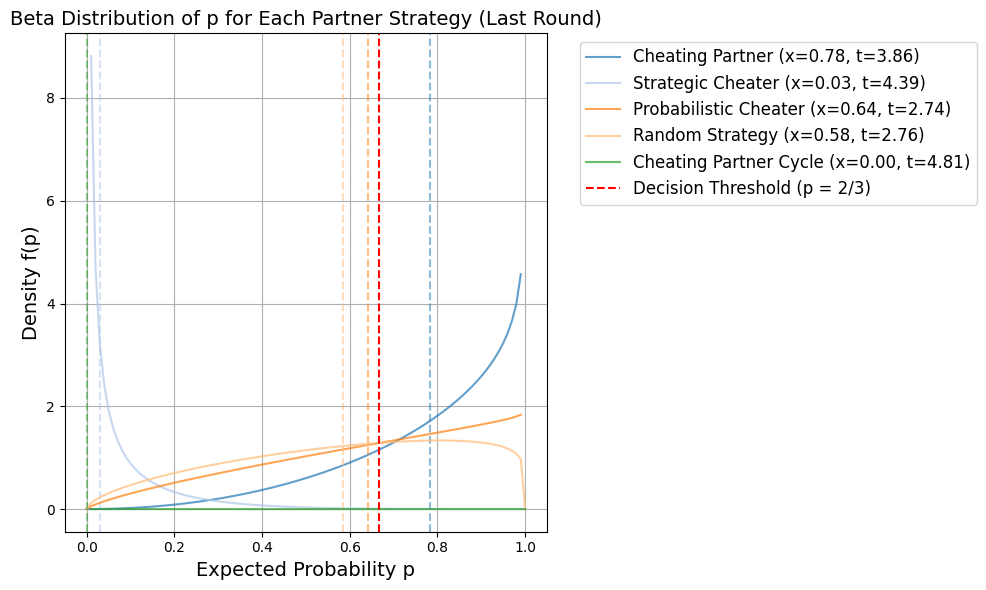

In [175]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# List of DataFrames and their corresponding strategy names
strategies_2 = [
    ("Cheating Partner", df_cheating),
    ("Strategic Cheater", df_strategic_cheater),
    ("Probabilistic Cheater", df_prob_cheater),
    ("Random Strategy", df_random),
    ("Cheating Partner Cycle", df_cheating_partner_cycle)

]

# Get x and t from the last round for each strategy
last_round_data = {}
for name, df in strategies_2:
    last_row = df.iloc[-1]  # Last round
    x = last_row["Agent_Signal"]
    t = last_row["Agent_Trust"]
    last_round_data[name] = (x, t)

# Plot the Beta distribution of p for each strategy
p = np.linspace(0, 1, 100)  # Values of p from 0 to 1
plt.figure(figsize=(10, 6))

# Use the same colors as in your previous plots for consistency
colors = sns.color_palette("tab20", 10)

for idx, (name, (x, t)) in enumerate(last_round_data.items()):
    # Compute α and β
    # Compute α and β
    alpha = EPS + x * t
    beta = EPS + (1 - x) * t
    # Compute the mean E[p]
    E_p = (alpha) / (alpha + beta)
    # Plot the Beta distribution
    plt.plot(p, stats.beta.pdf(p, alpha, beta), label=f"{name} (x={x:.2f}, t={t:.2f})",
             color=colors[idx], alpha=0.7)
    # Mark the mean E[p] with a vertical line
    plt.axvline(x=E_p, color=colors[idx], linestyle='--', alpha=0.5)

# Add the decision threshold
plt.axvline(x=2/3, color='red', linestyle='--', label='Decision Threshold (p = 2/3)')

plt.xlabel("Expected Probability p", fontsize=14)
plt.ylabel("Density f(p)", fontsize=14)
plt.title("Beta Distribution of p for Each Partner Strategy (Last Round)", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()



In [176]:
# Compare with decision-making trends
print("Decision-Making Trends in the Last Round:")
for name, df in strategies_1:
    last_choice = df.iloc[-1]["Agent_Choice"]
    last_row = df.iloc[-1]
    x, t = last_row["Agent_Signal"], last_row["Agent_Trust"]
    last_p = (EPS + x * t) / (2 * EPS + t)

    print(f"{name}: p = {last_p:.3f}, Choice = {'Stag' if last_choice == 1 else 'Hare'}")
    # Compare with decision-making trends
for name, df in strategies_2:
    last_choice = df.iloc[-1]["Agent_Choice"]
    last_row = df.iloc[-1]
    x, t = last_row["Agent_Signal"], last_row["Agent_Trust"]
    last_p = (EPS + x * t) / (2 * EPS + t)

    print(f"{name}: p = {last_p:.3f}, Choice = {'Stag' if last_choice == 1 else 'Hare'}")

Decision-Making Trends in the Last Round:
Always Collaborate: p = 0.979, Choice = Stag
Always Defect: p = 0.071, Choice = Hare
Adaptive Strategy: p = 0.063, Choice = Hare
Tit-for-Tat Cooperate: p = 0.055, Choice = Hare
Tit-for-Tat Defect: p = 0.074, Choice = Hare
Expectation Violation: p = 0.845, Choice = Stag
Cheating Partner: p = 0.784, Choice = Stag
Strategic Cheater: p = 0.030, Choice = Hare
Probabilistic Cheater: p = 0.641, Choice = Stag
Random Strategy: p = 0.584, Choice = Stag
Cheating Partner Cycle: p = 0.000, Choice = Hare


In [177]:
def cooperation_rate_2(df, who="Agent_Choice"):
    return df[who].mean()  # fraction of rounds with 1 (cooperate)

print("Agent coop rate:", cooperation_rate_2(df_tit_for_tat_coop))
print("Partner coop rate:", cooperation_rate_2(df_tit_for_tat_coop, who="Partner_Choice"))


Agent coop rate: 0.07142857142857142
Partner coop rate: 0.08571428571428572


In [178]:
def add_payoffs_2(df):
    df = df.copy()
    p1 = df["Agent_Choice"].astype(int).to_numpy()
    p2 = df["Partner_Choice"].astype(int).to_numpy()
    df["Agent_Payoff"] = payoff[p1, p2, 0]
    df["Partner_Payoff"] = payoff[p1, p2, 1]
    return df


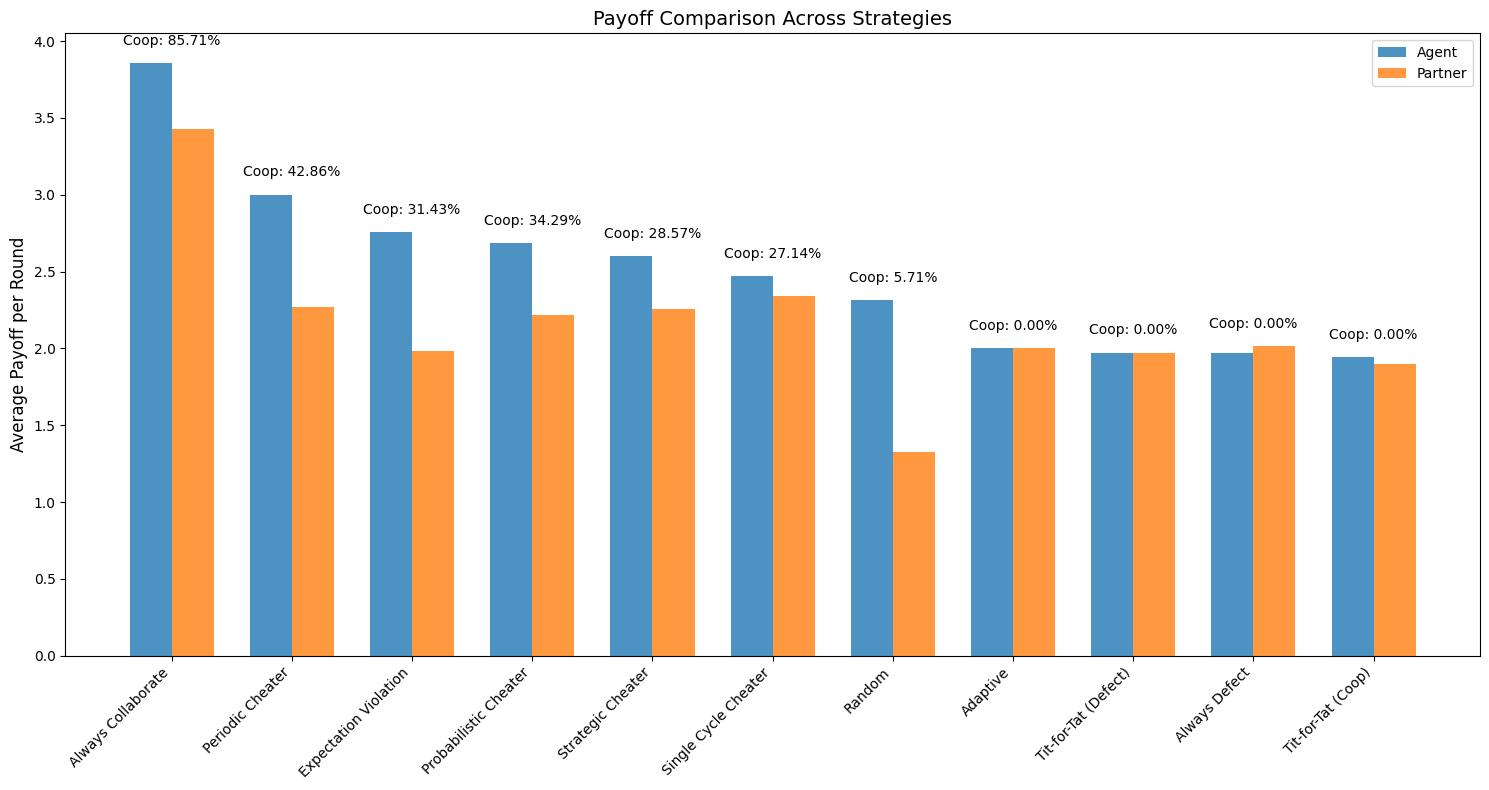


Detailed Strategy Analysis:
             Strategy  Total Agent Payoff  Total Partner Payoff  Avg Agent Payoff  Avg Partner Payoff  Mutual Cooperation Rate
   Always Collaborate                 270                   240              3.86                3.43                     0.86
     Periodic Cheater                 210                   159              3.00                2.27                     0.43
Expectation Violation                 193                   139              2.76                1.99                     0.31
Probabilistic Cheater                 188                   155              2.69                2.21                     0.34
    Strategic Cheater                 182                   158              2.60                2.26                     0.29
 Single Cycle Cheater                 173                   164              2.47                2.34                     0.27
               Random                 162                    93              2.31 

In [179]:
def analyze_payoffs(strategy_name: str, df: pd.DataFrame) -> dict:
    """Analyze payoffs for a given strategy."""
    df_with_payoff = add_payoffs_2(df)
    return {
        'Strategy': strategy_name,
        'Total Agent Payoff': df_with_payoff['Agent_Payoff'].sum(),
        'Total Partner Payoff': df_with_payoff['Partner_Payoff'].sum(),
        'Avg Agent Payoff': df_with_payoff['Agent_Payoff'].mean(),
        'Avg Partner Payoff': df_with_payoff['Partner_Payoff'].mean(),
        'Mutual Cooperation Rate': (df_with_payoff['Agent_Choice'] & df_with_payoff['Partner_Choice']).mean()
    }

# Analyze all strategies
strategy_results = pd.DataFrame([
    analyze_payoffs("Tit-for-Tat (Coop)", df_tit_for_tat_coop),
    analyze_payoffs("Tit-for-Tat (Defect)", df_tit_for_tat_defect),
    analyze_payoffs("Expectation Violation", df_expect_violation),
    analyze_payoffs("Periodic Cheater", df_cheating),
    analyze_payoffs("Single Cycle Cheater", df_cheating_partner_cycle),
    analyze_payoffs("Probabilistic Cheater", df_prob_cheater),
    analyze_payoffs("Strategic Cheater", df_strategic_cheater),
    analyze_payoffs("Always Collaborate", df_collab),
    analyze_payoffs("Always Defect", df_defect),
    analyze_payoffs("Random", df_random),
    analyze_payoffs("Adaptive", df_adaptive)
])

# Sort by total agent payoff to see most successful strategies
strategy_results = strategy_results.sort_values('Total Agent Payoff', ascending=False)

# Create visualization
plt.figure(figsize=(15, 8))
x = np.arange(len(strategy_results))
width = 0.35

plt.bar(x - width/2, strategy_results['Avg Agent Payoff'], width, label='Agent', alpha=0.8)
plt.bar(x + width/2, strategy_results['Avg Partner Payoff'], width, label='Partner', alpha=0.8)

plt.ylabel('Average Payoff per Round', fontsize=12)
plt.title('Payoff Comparison Across Strategies', fontsize=14)
plt.xticks(x, strategy_results['Strategy'], rotation=45, ha='right')
plt.legend()

# Add cooperation rate as text on top of bars
for i, row in enumerate(strategy_results.itertuples()):
    plt.text(i, max(row._4, row._5) + 0.1, 
             f'Coop: {row._6:.2%}', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Strategy Analysis:")
print(strategy_results.round(2).to_string(index=False))

In [180]:
df_expect_violation = pd.DataFrame(sim_results_expect_violation)
df_expect_violation

,Round,Agent_Choice,Partner_Choice,Agent_Signal,Agent_Trust,E_p
0,1,0,1,0.332344,0.000000,0.500000
1,2,0,1,0.376655,0.000000,0.500000
2,3,1,1,0.442319,0.000000,0.500000
3,4,0,1,0.503870,0.000000,0.500000
4,5,0,1,0.540728,0.000000,0.500000
...,...,...,...,...,...,...
65,66,0,1,0.817093,3.220375,0.817093
66,67,1,1,0.852187,3.393350,0.852187
67,68,0,1,0.858038,3.551022,0.858038
68,69,1,1,0.863185,3.694124,0.863185


In [181]:
def add_payoffs(df: pd.DataFrame) -> pd.DataFrame:
    p1 = df["Agent_Choice"].astype(int).to_numpy()
    p2 = df["Partner_Choice"].astype(int).to_numpy()
    out = df.copy()
    out["Agent_Payoff"]   = payoff[p1, p2, 0]
    out["Partner_Payoff"] = payoff[p1, p2, 1]
    return out

def agent_coop_rate(df: pd.DataFrame) -> float:
    return float(df["Agent_Choice"].mean())

def time_to_threshold(df: pd.DataFrame, p_star: float | None = None, direction: str | None = None) -> float | None:
    """
    First round index (1-based like 'Round') when E[p] crosses p_star.
    If direction is:
      - 'up': first time E[p] >= p_star
      - 'down': first time E[p] <= p_star
      - None: any crossing of p_star from either side (first index where sign(E[p]-p*) flips vs previous)
    Returns None if no crossing.
    """
    if p_star is None:
        p_star = stag_indifference_threshold()
    E = df["E_p"].to_numpy()
    if len(E) == 0: return None

    if direction == "up":
        idx = np.where(E >= p_star)[0]
        return int(df["Round"].iloc[idx[0]]) if idx.size>0 else None
    elif direction == "down":
        idx = np.where(E <= p_star)[0]
        return int(df["Round"].iloc[idx[0]]) if idx.size>0 else None
    else:
        # any first crossing relative to initial side
        sign0 = np.sign(E[0] - p_star)
        for i in range(1, len(E)):
            if np.sign(E[i] - p_star) != sign0:
                return int(df["Round"].iloc[i])
        return None

def final_decision(df: pd.DataFrame) -> int:
    return int(df["Agent_Choice"].iloc[-1])


In [182]:
from itertools import product

def sweep_learning_params(
    partner_factory,
    eta_grid = np.linspace(0.0, 1.0, 6),
    memory_discount_grid = np.linspace(0.0, 1.0, 6),
    trust_discount_grid = np.linspace(0.0, 1.0, 6),
    trust_smoothing_grid = np.linspace(0.0, 1.0, 6),
    seeds = (101, 202),
    num_rounds = 70,
    threshold_direction: str | None = None,  # 'up' or 'down' or None
) -> pd.DataFrame:
    """
    partner_factory: a callable returning a FRESH partner object (e.g., lambda: RandomPartner()).
    """
    rows = []
    p_star = stag_indifference_threshold()

    for eta, md, td, ts in product(eta_grid, memory_discount_grid, trust_discount_grid, trust_smoothing_grid):
        for seed in seeds:
            partner = partner_factory()  # fresh partner instance
            df = run_single_agent_simulation(
                u_i=None,
                stochastic=True,
                inv_temp=2.0,
                seed=seed,
                num_rounds=num_rounds,
                partner_obj=partner,
                memory_discount=md,
                trust_discount=td,
                trust_smoothing=ts,
                eta=eta
            )
            # compute requested outputs
            row = {
                "eta": eta,
                "memory_discount": md,
                "trust_discount": td,
                "trust_smoothing": ts,
                "seed": seed,
                "agent_coop_rate": agent_coop_rate(df),
                "E_p_last": float(df["E_p"].iloc[-1]),
                "final_decision": final_decision(df),
                "time_to_threshold": time_to_threshold(df, p_star=p_star, direction=threshold_direction)
            }
            rows.append(row)
    return pd.DataFrame(rows)


In [183]:
# Stationary cooperative
df_sens_C = sweep_learning_params(lambda: AlwaysCollaboratePartner(),
                                  eta_grid=np.linspace(0.05,0.6,4),
                                  memory_discount_grid=np.linspace(0.5,0.99,4),
                                  trust_discount_grid=np.linspace(0.2,0.99,4),
                                  trust_smoothing_grid=np.linspace(0.05,0.5,4),
                                  seeds=(11,22,33),
                                  num_rounds=70,
                                  threshold_direction="up")   # expecting E[p] to go above p*

# Stationary defect
df_sens_D = sweep_learning_params(lambda: AlwaysDefectPartner(),
                                  seeds=(11,22,33),
                                  threshold_direction="down") # expecting E[p] to go below p*

# Switching partner (cooperate 30 rounds, then defect)
K = 30
df_switch = sweep_learning_params(lambda: SingleCyclePartner(cooperate_rounds=K),
                                  seeds=(11,22,33),
                                  num_rounds=70,
                                  # after round K, "down" is the correct direction
                                  threshold_direction="down")


In [184]:
# Which knobs most move agent_coop_rate (one-way means)?
df_sens_C.groupby("eta")["agent_coop_rate"].mean().sort_values(ascending=False)

# Probability of choosing Stag in the end (final_decision==1) by trust_smoothing
df_sens_C.assign(stag_final = (df_sens_C.final_decision==1).astype(int)) \
          .groupby("trust_smoothing")["stag_final"].mean()

# Time to threshold (smaller is better for detection)
df_switch.groupby("memory_discount")["time_to_threshold"].median()


memory_discount
0.0    1.0
0.2    1.0
0.4    1.0
0.6    1.0
0.8    1.0
1.0    1.0
Name: time_to_threshold, dtype: float64

In [185]:
# Create a test instance of FocalAgent
agent = FocalAgent(
    u_i=0.66,  # initial signal
    t_init=0.0,  # initial trust
    stochastic=True,  # use stochastic decision making
    inv_temp=2.0  # inverse temperature for logistic function
)

# Test make_decision multiple times to see the stochastic behavior
print("Testing FocalAgent decisions:")
print("\nState:")
print(f"Signal (x) = {agent.x:.3f}")
print(f"Trust (t) = {agent.t:.3f}")
print(f"Expected p = {agent.expected_p():.3f}")

print("\nDecisions over 10 trials:")
for i in range(10):
    decision = agent.make_decision()
    print(f"Trial {i+1}: {'Stag' if decision == 1 else 'Hare'}")

# Test with different trust levels
test_trusts = [0.5, 2.0, 4.0]
test_signals = [0.3, 0.5, 0.8]

print("\nTesting decisions with different trust and signal levels:")
for t in test_trusts:
    for x in test_signals:
        agent.t = t
        agent.x = x
        decisions = [agent.make_decision() for _ in range(5)]
        stag_ratio = sum(decisions) / len(decisions)
        print(f"\nt={t:.1f}, x={x:.1f}:")
        print(f"Expected p = {agent.expected_p():.3f}")
        print(f"Stag choice ratio = {stag_ratio:.2%}")

Testing FocalAgent decisions:

State:
Signal (x) = 0.660
Trust (t) = 0.000
Expected p = 0.500

Decisions over 10 trials:
Trial 1: Hare
Trial 2: Hare
Trial 3: Hare
Trial 4: Hare
Trial 5: Hare
Trial 6: Stag
Trial 7: Hare
Trial 8: Hare
Trial 9: Stag
Trial 10: Stag

Testing decisions with different trust and signal levels:

t=0.5, x=0.3:
Expected p = 0.300
Stag choice ratio = 0.00%

t=0.5, x=0.5:
Expected p = 0.500
Stag choice ratio = 40.00%

t=0.5, x=0.8:
Expected p = 0.800
Stag choice ratio = 80.00%

t=2.0, x=0.3:
Expected p = 0.300
Stag choice ratio = 0.00%

t=2.0, x=0.5:
Expected p = 0.500
Stag choice ratio = 0.00%

t=2.0, x=0.8:
Expected p = 0.800
Stag choice ratio = 40.00%

t=4.0, x=0.3:
Expected p = 0.300
Stag choice ratio = 20.00%

t=4.0, x=0.5:
Expected p = 0.500
Stag choice ratio = 40.00%

t=4.0, x=0.8:
Expected p = 0.800
Stag choice ratio = 40.00%


In [186]:
lambda_1 = 2.0  # temperature for partner's decision
for i in range(5):
    for t in [0.0, 0.5, 2.5, 4.0, 5.0]:
        for x in [0.3, 0.6, 1.0]:
            E_p = (EPS + x*t) / (2*EPS + t)
            E_H = 2 + E_p
            E_S = 4 * E_p
            Dif = E_S - E_H
            print(f"E[p]={E_p:.3f}, E[H]={E_H:.3f}, E[S]={E_S:.3f}, Dif={Dif:.3f}")
            
            P_S = 1.0 / (1.0 + np.exp(-lambda_1 * Dif))
            print(1 if random.random() < P_S else 0)
            print(f"t={t:.1f}, x={x:.1f}, P(S)={P_S:.3f}")

E[p]=0.500, E[H]=2.500, E[S]=2.000, Dif=-0.500
0
t=0.0, x=0.3, P(S)=0.269
E[p]=0.500, E[H]=2.500, E[S]=2.000, Dif=-0.500
1
t=0.0, x=0.6, P(S)=0.269
E[p]=0.500, E[H]=2.500, E[S]=2.000, Dif=-0.500
0
t=0.0, x=1.0, P(S)=0.269
E[p]=0.300, E[H]=2.300, E[S]=1.200, Dif=-1.100
0
t=0.5, x=0.3, P(S)=0.100
E[p]=0.600, E[H]=2.600, E[S]=2.400, Dif=-0.200
0
t=0.5, x=0.6, P(S)=0.401
E[p]=1.000, E[H]=3.000, E[S]=4.000, Dif=1.000
1
t=0.5, x=1.0, P(S)=0.881
E[p]=0.300, E[H]=2.300, E[S]=1.200, Dif=-1.100
0
t=2.5, x=0.3, P(S)=0.100
E[p]=0.600, E[H]=2.600, E[S]=2.400, Dif=-0.200
1
t=2.5, x=0.6, P(S)=0.401
E[p]=1.000, E[H]=3.000, E[S]=4.000, Dif=1.000
1
t=2.5, x=1.0, P(S)=0.881
E[p]=0.300, E[H]=2.300, E[S]=1.200, Dif=-1.100
0
t=4.0, x=0.3, P(S)=0.100
E[p]=0.600, E[H]=2.600, E[S]=2.400, Dif=-0.200
0
t=4.0, x=0.6, P(S)=0.401
E[p]=1.000, E[H]=3.000, E[S]=4.000, Dif=1.000
1
t=4.0, x=1.0, P(S)=0.881
E[p]=0.300, E[H]=2.300, E[S]=1.200, Dif=-1.100
0
t=5.0, x=0.3, P(S)=0.100
E[p]=0.600, E[H]=2.600, E[S]=2.400, Dif=-

In [187]:
for t in [0.0, 0.5, 2.5, 5.0, 10.0]:
        for x in [0.0, 0.3, 0.6, 1.0]:
            E_p = (EPS + x*t) / (2*EPS + t)
            E_H = 2 + E_p
            E_S = 4 * E_p
            Dif = E_S - E_H
            print(f"t={t:.1f}, x={x:.1f}")
            print(f"E[p]={E_p:.3f}, E[H]={E_H:.3f}, E[S]={E_S:.3f}, Dif={Dif:.3f}")

t=0.0, x=0.0
E[p]=0.500, E[H]=2.500, E[S]=2.000, Dif=-0.500
t=0.0, x=0.3
E[p]=0.500, E[H]=2.500, E[S]=2.000, Dif=-0.500
t=0.0, x=0.6
E[p]=0.500, E[H]=2.500, E[S]=2.000, Dif=-0.500
t=0.0, x=1.0
E[p]=0.500, E[H]=2.500, E[S]=2.000, Dif=-0.500
t=0.5, x=0.0
E[p]=0.000, E[H]=2.000, E[S]=0.000, Dif=-2.000
t=0.5, x=0.3
E[p]=0.300, E[H]=2.300, E[S]=1.200, Dif=-1.100
t=0.5, x=0.6
E[p]=0.600, E[H]=2.600, E[S]=2.400, Dif=-0.200
t=0.5, x=1.0
E[p]=1.000, E[H]=3.000, E[S]=4.000, Dif=1.000
t=2.5, x=0.0
E[p]=0.000, E[H]=2.000, E[S]=0.000, Dif=-2.000
t=2.5, x=0.3
E[p]=0.300, E[H]=2.300, E[S]=1.200, Dif=-1.100
t=2.5, x=0.6
E[p]=0.600, E[H]=2.600, E[S]=2.400, Dif=-0.200
t=2.5, x=1.0
E[p]=1.000, E[H]=3.000, E[S]=4.000, Dif=1.000
t=5.0, x=0.0
E[p]=0.000, E[H]=2.000, E[S]=0.000, Dif=-2.000
t=5.0, x=0.3
E[p]=0.300, E[H]=2.300, E[S]=1.200, Dif=-1.100
t=5.0, x=0.6
E[p]=0.600, E[H]=2.600, E[S]=2.400, Dif=-0.200
t=5.0, x=1.0
E[p]=1.000, E[H]=3.000, E[S]=4.000, Dif=1.000
t=10.0, x=0.0
E[p]=0.000, E[H]=2.000, E[S]=

In [188]:
Dif_1 = [-2, -1, -0.5, 0, 0.5, 0.8, 1]  # difference values 
lambda_2 = [0.5, 1, 1.5, 2, 3, 5, 10]  # temperature for agent's decision

for i in Dif_1:
    for j in lambda_2:
        P_S_1 = 1.0 / (1.0 + np.exp(-j * i))
        print(f"lambda={j:.1f}, diff={i:.1f}, P(S)={P_S_1:.3f}")

lambda=0.5, diff=-2.0, P(S)=0.269
lambda=1.0, diff=-2.0, P(S)=0.119
lambda=1.5, diff=-2.0, P(S)=0.047
lambda=2.0, diff=-2.0, P(S)=0.018
lambda=3.0, diff=-2.0, P(S)=0.002
lambda=5.0, diff=-2.0, P(S)=0.000
lambda=10.0, diff=-2.0, P(S)=0.000
lambda=0.5, diff=-1.0, P(S)=0.378
lambda=1.0, diff=-1.0, P(S)=0.269
lambda=1.5, diff=-1.0, P(S)=0.182
lambda=2.0, diff=-1.0, P(S)=0.119
lambda=3.0, diff=-1.0, P(S)=0.047
lambda=5.0, diff=-1.0, P(S)=0.007
lambda=10.0, diff=-1.0, P(S)=0.000
lambda=0.5, diff=-0.5, P(S)=0.438
lambda=1.0, diff=-0.5, P(S)=0.378
lambda=1.5, diff=-0.5, P(S)=0.321
lambda=2.0, diff=-0.5, P(S)=0.269
lambda=3.0, diff=-0.5, P(S)=0.182
lambda=5.0, diff=-0.5, P(S)=0.076
lambda=10.0, diff=-0.5, P(S)=0.007
lambda=0.5, diff=0.0, P(S)=0.500
lambda=1.0, diff=0.0, P(S)=0.500
lambda=1.5, diff=0.0, P(S)=0.500
lambda=2.0, diff=0.0, P(S)=0.500
lambda=3.0, diff=0.0, P(S)=0.500
lambda=5.0, diff=0.0, P(S)=0.500
lambda=10.0, diff=0.0, P(S)=0.500
lambda=0.5, diff=0.5, P(S)=0.562
lambda=1.0, diff=0

In [189]:
jj = 1.0 / (1.0 + np.exp(1))
print(f"lambda=1, diff=-2, P(S)={jj:.3f}")

lambda=1, diff=-2, P(S)=0.269


In [190]:
a = np.exp(1.0)
b = np.exp(2.0)
c = np.exp(3.0)
d = np.exp(4.0)     
g = np.exp(-1.0)
f = np.exp(-2.0)
h = np.exp(-3.0)
print(a, b, c, d)
print(f, g, h)

2.718281828459045 7.38905609893065 20.085536923187668 54.598150033144236
0.1353352832366127 0.36787944117144233 0.049787068367863944


In [191]:
a_plus = random.random()
b_plus = random.random()
c_plus = random.random()
d_plus = random.random()
g_plus = random.random()
f_plus = random.random()
h_plus = random.random()
print(a_plus, b_plus, c_plus, d_plus)
print(f_plus, g_plus, h_plus)

0.19942136759503926 0.8831252069666595 0.4300492320773812 0.8125578068814661
0.7302360488822621 0.28396368236710845 0.9074662872508675


In [192]:
hhh = np.exp(-0.1)
print(hhh)

0.9048374180359595


In [193]:
kkk = 1/(1+hhh)
print(kkk)

0.52497918747894


In [194]:
aaa = 1e-6 + (0.667*3)
print(aaa)

2.0010010000000005


In [195]:
aaaaaa = 1e-6*2 + 3
print(aaaaaa)

3.000002


In [196]:
ll =np.log(0.8) / 2
print(ll)

-0.11157177565710485


In [197]:
lllll = ll/0.1
print(lllll)

-1.1157177565710485


In [198]:
1.9/3

0.6333333333333333